# 수염 스티커 합성하기

## 관련 라이브러리 import
+ 얼굴 탐지와 랜드마크 검출엔 OpenCV가 아닌 dlib를 사용해서 구현
+ HOG+SVM으로 얼굴 탐지(bounding box 생성)

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 이미지 불러오기 및 시각화

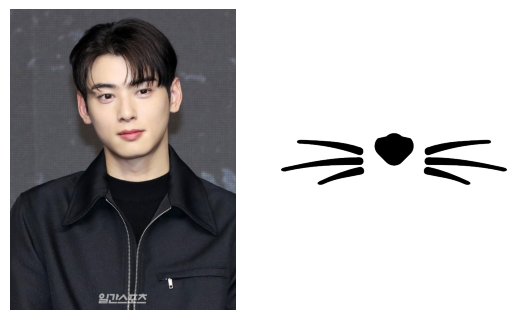

In [3]:
image_person_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/data/camera_sticker/images/face1.png'
image_whisker_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/data/camera_sticker/images/cat-whiskers.png'

# 이미지 불러오기
img_person = cv2.imread(image_person_path, 1) # 1: color(alpha 제외), 0: grayscale, -1: alpha 채널까지 포함
img_whisker = cv2.imread(image_whisker_path, -1) # 알파 채널까지 읽기
# 출력용 이미지(bounding box와 keypoint 점들을 그림)
img_person_show = img_person.copy()

# RGB데이터로 바꾸기
img_person = cv2.cvtColor(img_person, cv2.COLOR_BGR2RGB)
img_person_show = cv2.cvtColor(img_person_show, cv2.COLOR_BGR2RGB)
# 알파채널까지 유지
img_whisker = cv2.cvtColor(img_whisker, cv2.COLOR_BGRA2RGBA)

# 이미지 출력
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img_person)
axes[1].imshow(img_whisker)
axes[0].axis('off')
axes[1].axis('off')
plt.show()

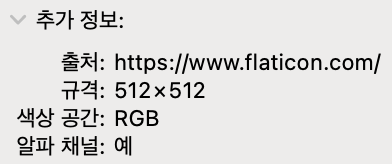

알파 채널이 존재하기 때문에 수염 이미지는 알파채널까지 읽어온다.

In [4]:
# 메타 데이터 확인
print(img_whisker.shape)
print(img_whisker.dtype)

(512, 512, 4)
uint8


## bounding box 생성

In [5]:
# face detector 선언(HOG + SVM)
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출
bounding_boxes = detector_hog(img_person, 1)

bounding box coordinate: rectangles[[(375, 290) (760, 675)]]


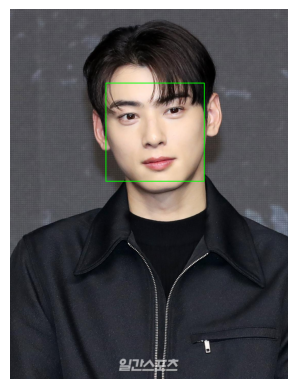

In [6]:
# bounding box 좌표 출력
print('bounding box coordinate:', bounding_boxes)

for box in bounding_boxes: # 찾은 얼굴 영역의 좌표
    l = box.left() # 왼쪽 위 꼭짓점 x좌표
    t = box.top() # 왼쪽 위 꼭짓점 y좌표
    r = box.right() # 오른쪽 아래 꼭짓점 x좌표
    b = box.bottom() # 오른쪽 아래 꼭짓점 y좌표

    # 양 꼭짓점을 이용해 img_person 위에 직각 사각형을 그림
    cv2.rectangle(img_person_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_person_show)
plt.axis('off')
plt.show()

## dlib에서 제공하는 사전학습된 face landmark detection 모델 사용
+ 회귀 트리를 앙상블한 모델

In [7]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv /content/shape_predictor_68_face_landmarks.dat.bz2 '/content/drive/MyDrive/Colab Notebooks/Aiffel/data/camera_sticker/models'
!bzip2 -d "/content/drive/MyDrive/Colab Notebooks/Aiffel/data/camera_sticker/models/shape_predictor_68_face_landmarks.dat.bz2"

--2025-04-10 14:46:11--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-04-10 14:46:11--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  13.2MB/s    in 5.9s    

2025-04-10 14:46:18 (10.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file /content/drive/MyDrive/Colab Notebooks/Aiffel/data/camera_sticker/models/shape_predictor_68_face_landmarks.dat already exists.


## 랜드마크 추출

In [8]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/data/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
# dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크의 위치를 저장할 리스트
list_landmarks = []

# 여기선 얼굴이 하나이므로 한 번만 돎
for box in bounding_boxes:
    # 이미지와 bounding box를 넘겨주어 랜드마크를 반환
    points = landmark_predictor(img_person, box)
    # 각각의 랜드마크 위치정보를 (x,y) 형태로 변환
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # list_landmarks에 랜드마크 리스트를 저장 -> 얼굴이 1개 이므로 1개 리스트만 저장
    list_landmarks.append(list_points)

# 68
print(len(list_landmarks[0]))

68


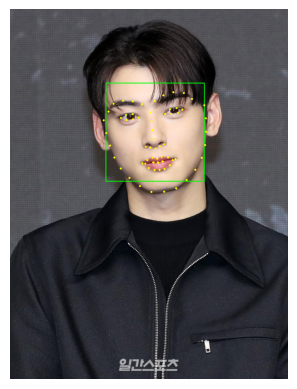

In [9]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행
for landmark in list_landmarks:
    for point in landmark:
        # img_person_show 이미지 위 각각의 point에 크기가 4이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
        cv2.circle(img_person_show, point, 4, (255, 255, 0), -1)

plt.imshow(img_person_show)
plt.axis('off')
plt.show()

## 스티커 적용하기
+ 인중(코 끝(33)과 입술 위(51) 사이)에 스티커 가운데가 오도록 배치
+ x 좌표: 33
+ y 좌표: 33과 51의 중앙
+ 너비(w): 입술 길이
+ 높이(h): 원본의 가로세로 비를 유지하여 w에 맞게 조정

In [10]:
for dlib_rect, landmark in zip(bounding_boxes, list_landmarks):
    print(landmark[33])
    x = landmark[33][0]
    y = (landmark[33][1] + landmark[51][1]) // 2

    # 원본이미지 높이/너비 계산
    aspect_ratio = img_whisker.shape[0] / img_whisker.shape[1]
    # 입 양 끝점 사이의 가로 거리 계산
    w = landmark[54][0] - landmark[48][0]
    # 비율을 유지하며 높이 계산
    h = int(w * aspect_ratio)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(569, 546)
(x,y) : (569,566)
(w,h) : (129,129)


In [11]:
img_whisker = cv2.resize(img_whisker, (w,h)) # 이미지 크기 조정
print (img_whisker.shape) # 조정된 크기 확인

(129, 129, 4)


In [12]:
# 스티커를 붙일 시작 좌표 계산
refined_x = x - (w // 2)
refined_y = y - (h // 2)
print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (505,502)


### 스티커 시작 좌표가 음수가 될 경우 예외처리
+ 음수값 만큼 스티커 이미지를 crop하는 방식으로 예외처리


In [13]:
if refined_x < 0:
    img_whisker = img_whisker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_whisker = img_whisker[-refined_y:, :] # refined_y가 -98일 경우, img_whisker[98: , :]가 된다. (129, 129, 4)에서 (31, 129, 4)가 된다.
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (505,502)


In [14]:
whisker_area = img_person_show[refined_y:refined_y+img_whisker.shape[0], refined_x:refined_x+img_whisker.shape[1]]

In [15]:
# 투명한 픽셀에 대한 마스크 생성(2차원 불리언 배열)
transparency_mask = img_whisker[:,:,3]==0
# np.where 함수 사용을 위해 3차원으로 공간 확장
transparency_mask = transparency_mask[:,:,np.newaxis].repeat(3, axis=2)

# 투명하지 않은 픽셀은 img_whisker, 투명한 픽셀은 whisker_area로 기존 이미지를 덮어씌움
img_person_show[refined_y:refined_y+img_whisker.shape[0], refined_x:refined_x+img_whisker.shape[1]] = \
    np.where(transparency_mask,whisker_area,img_whisker[:,:,:3]).astype(np.uint8)

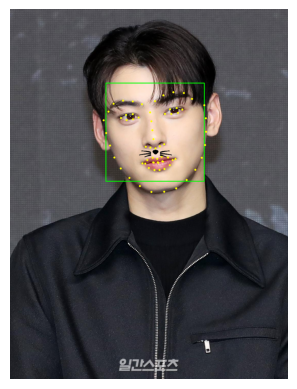

In [16]:
# 수염 이미지를 적용한 이미지를 보여준다.
plt.imshow(img_person_show)
plt.axis('off')
plt.show()

## 최종 결과 출력
+ 원본데이터인 img_person을 이용하여 위 과정을 반복한다.

In [17]:
whisker_area = img_person[refined_y:refined_y+img_whisker.shape[0], refined_x:refined_x+img_whisker.shape[1]]

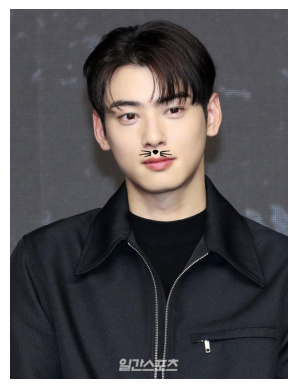

In [18]:
img_person[refined_y:refined_y+img_whisker.shape[0], refined_x:refined_x+img_whisker.shape[1]] = \
    np.where(transparency_mask,whisker_area,img_whisker[:,:,:3]).astype(np.uint8)
plt.imshow(img_person)
plt.axis('off')
plt.show()

# 문제상황 가정

## 다양한 얼굴 각도

In [19]:
# 이미지 생성 과정을 함수화
def add_whisker_to_face(img_person_path, img_whisker_path):
  img_person = cv2.imread(img_person_path, 1) # 1: color(alpha 제외), 0: grayscale, -1: alpha 채널까지 포함
  img_person_show = img_person.copy()
  img_whisker = cv2.imread(img_whisker_path, -1) # 알파 채널까지 읽기

  # RGB데이터로 바꾸기
  img_person = cv2.cvtColor(img_person, cv2.COLOR_BGR2RGB)
  img_person_show = cv2.cvtColor(img_person_show, cv2.COLOR_BGR2RGB)
  img_whisker = cv2.cvtColor(img_whisker, cv2.COLOR_BGRA2RGBA)

  # face detector 선언(HOG + SVM)
  detector_hog = dlib.get_frontal_face_detector()

  # bounding box 추출
  bounding_boxes = detector_hog(img_person, 1)

  # bounding box를 추출하지 못했을 때 예외처리
  if len(bounding_boxes) == 0:
    print("얼굴을 찾을 수 없습니다.")

    return img_person_show, img_person

  for box in bounding_boxes: # 찾은 얼굴 영역의 좌표
      l = box.left() # 왼쪽 위 꼭짓점 x좌표
      t = box.top() # 왼쪽 위 꼭짓점 y좌표
      r = box.right() # 오른쪽 아래 꼭짓점 x좌표
      b = box.bottom() # 오른쪽 아래 꼭짓점 y좌표

      # 양 꼭짓점을 이용해 img_person 위에 직각 사각형을 그림
      cv2.rectangle(img_person_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

  # 랜드마크의 위치를 저장할 리스트
  list_landmarks = []

  for box in bounding_boxes:
      # 이미지와 bounding box를 넘겨주어 랜드마크를 반환
      points = landmark_predictor(img_person, box)
      # 각각의 랜드마크 위치정보를 (x,y) 형태로 변환
      list_points = list(map(lambda p: (p.x, p.y), points.parts()))
      # list_landmarks에 랜드마크 리스트를 저장 -> 얼굴이 1개 이므로 1개 리스트만 저장
      list_landmarks.append(list_points)

  # list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행
  for landmark in list_landmarks:
      for point in landmark:
          # img_person_show 이미지 위 각각의 point에 크기가 4이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
          cv2.circle(img_person_show, point, 4, (255, 255, 0), -1)

  for dlib_rect, landmark in zip(bounding_boxes, list_landmarks):
      x = landmark[33][0]
      y = (landmark[33][1] + landmark[51][1]) // 2

      # 원본이미지 높이/너비 계산
      aspect_ratio = img_whisker.shape[0] / img_whisker.shape[1]
      # 입 양 끝점 사이의 가로 거리 계산
      w = landmark[54][0] - landmark[48][0]
      # 비율을 유지하며 높이 계산
      h = int(w * aspect_ratio)

  img_whisker = cv2.resize(img_whisker, (w,h)) # 이미지 크기 조정

  # 스티커를 붙일 시작 좌표 계산
  refined_x = x - (w // 2)
  refined_y = y - (h // 2)

  if refined_x < 0:
      img_whisker = img_whisker[:, -refined_x:]
      refined_x = 0

  if refined_y < 0:
      img_whisker = img_whisker[-refined_y:, :] # refined_y가 -98일 경우, img_whisker[98: , :]가 된다. (129, 129, 4)에서 (31, 129, 4)가 된다.
      refined_y = 0


  whisker_area_with_points = img_person_show[refined_y:refined_y+img_whisker.shape[0], refined_x:refined_x+img_whisker.shape[1]]

  # 투명한 픽셀에 대한 마스크 생성(2차원 불리언 배열)
  transparency_mask = img_whisker[:,:,3]==0
  # np.where 함수 사용을 위해 3차원으로 공간 확장
  transparency_mask = transparency_mask[:,:,np.newaxis].repeat(3, axis=2)

  # 투명하지 않은 픽셀은 img_whisker, 투명한 픽셀은 whisker_area_with_points로 기존 이미지를 덮어씌움
  img_person_show[refined_y:refined_y+img_whisker.shape[0], refined_x:refined_x+img_whisker.shape[1]] = \
      np.where(transparency_mask,whisker_area_with_points,img_whisker[:,:,:3]).astype(np.uint8)


  whisker_area = img_person[refined_y:refined_y+img_whisker.shape[0], refined_x:refined_x+img_whisker.shape[1]]
  img_person[refined_y:refined_y+img_whisker.shape[0], refined_x:refined_x+img_whisker.shape[1]] = \
  np.where(transparency_mask,whisker_area,img_whisker[:,:,:3]).astype(np.uint8)

  return img_person_show, img_person

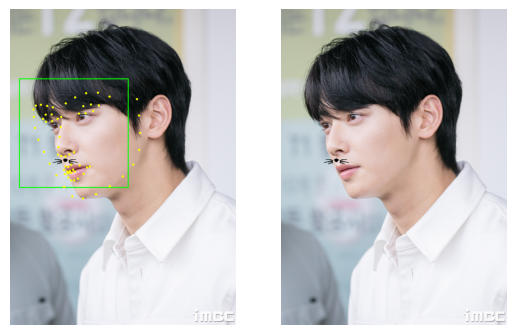

In [20]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/data/camera_sticker/images/face2.png'
result_with_points, result = add_whisker_to_face(image_path, image_whisker_path)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(result_with_points)
axes[1].imshow(result)
axes[0].axis('off')
axes[1].axis('off')
plt.show()

약간의 옆모습에 대해선 괜찮은 성능을 보여줬다.

얼굴을 찾을 수 없습니다.


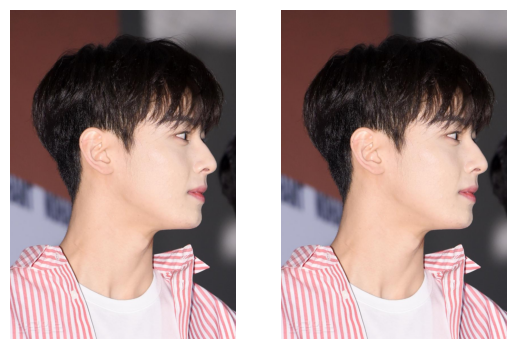

In [21]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/data/camera_sticker/images/face3.png'
result_with_points, result = add_whisker_to_face(image_path, image_whisker_path)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(result_with_points)
axes[1].imshow(result)
axes[0].axis('off')
axes[1].axis('off')
plt.show()

완전한 옆모습에 대해선 bounding box를 형성하는 부분을 처리하지 못했다.
이를 해결하기 위해선 다른 딥러닝 모델을 사용할 수 있을 거 같다.

# 회고
+ 딥러닝 외에 전통적인 알고리즘과 간단한 머신러닝 알고리즘의 조합으로도 좋고 빠른 객체 탐지가 가능한 것을 알았다.
+ 이미지 좌표와 픽셀 좌표가 헷갈리는데 주의해야겠다...
+ 옆모습 이미지에 대해선 keypoint detection 부분에서 실패할 줄 알았는데 얼굴 탐지에서 실패한 게 생각 외 부분이었다.